In [1]:
import os
import argparse

import numpy as np
np.float = np.float64
np.int = np.int_

from tqdm import tqdm
from PIL import Image
import open3d.t as o3d
import skvideo.io
import torch
import gc
from matplotlib import cm, patches
import matplotlib.pyplot as plt
import open3d as o3d
from configs.loader import cfg
from Model.models import *
from Model.tracker import *

from utils.geometry import *
from utils.io import load_conf, load_intrinsics, load_poses, load_depth
from utils.mask import *
from utils.graph import *
from utils.logger import *
import os
from datetime import datetime
import build_map

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from utils.relations import *

In [3]:
from utils.logger import *

In [50]:
logger = build_logger("")
tracker, _ = load_full_tracker("outputs/exp_20251201_112045/checkpoints", logger)

[11:34:23] [INFO] [Resume] Loading tracker checkpoint from: outputs/exp_20251201_112045/checkpoints
[11:34:23] [INFO] [Resume] Loaded object_0000
[11:34:23] [INFO] [Resume] Loaded object_0001
[11:34:23] [INFO] [Resume] Loaded object_0002
[11:34:23] [INFO] [Resume] Loaded object_0003
[11:34:23] [INFO] [Resume] Loaded object_0004
[11:34:23] [INFO] [Resume] Loaded object_0005
[11:34:23] [INFO] [Resume] Loaded object_0006
[11:34:23] [INFO] [Resume] Loaded object_0007
[11:34:23] [INFO] [Resume] Loaded object_0008
[11:34:23] [INFO] [Resume] Loaded object_0009
[11:34:23] [INFO] [Resume] Loaded object_0010
[11:34:23] [INFO] [Resume] Loaded object_0011
[11:34:23] [INFO] [Resume] Loaded object_0012
[11:34:23] [INFO] [Resume] Loaded object_0013
[11:34:23] [INFO] [Resume] Loaded object_0014
[11:34:23] [INFO] [Resume] Loaded object_0015
[11:34:23] [INFO] [Resume] Loaded object_0016
[11:34:23] [INFO] [Resume] Loaded object_0017
[11:34:23] [INFO] [Resume] Loaded object_0018
[11:34:23] [INFO] [Resume]

In [29]:
sorted_objects = sorted(tracker.objects, key=lambda obj: np.prod(obj.bbox.get_extent()), reverse=True)

In [46]:
sorted_objects[3].class_name

'wooden office door'

In [44]:
(sorted_objects[3].bbox.get_extent())

array([     4.7265,      2.4544,       1.766])

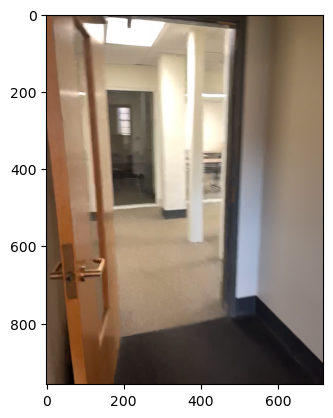

In [40]:
plt.imshow(sorted_objects[5].crops[0][0])
plt.show()

In [41]:
import open3d as o3d
o3d.io.write_point_cloud("max_obj.ply", sorted_objects[1].pcd)

True

In [51]:
from graph import plot_scene_graph_over_floorplan_manual

In [53]:
plot_scene_graph_over_floorplan_manual(tracker, FLOOR_OFFSET_X=-57, FLOOR_OFFSET_Y=-12, FLOOR_ROTATION_DEG=0)

[saved] scene_graph_2d.html


In [ ]:
obj = tracker.objects[230]
print(obj.class_name)
o3d.io.write_point_cloud("temp.ply", obj.pcd)
plt.imshow(obj.crops[0][0])
plt.show()

In [ ]:
combined, selected =build_map.combine_crops(obj)

In [ ]:
plt.imshow(combined)
plt.show()

In [ ]:
def plot_topdown_with_objects_bbox(tracker, canvas, figsize=(14, 14)):
    """
    Draw all objects on a single top-down map, using *true object size*
    from their point cloud bounding boxes projected onto X–Z.
    """

    img    = canvas["img"]     # (Hc, Wc, 3)
    count  = canvas["count"]   # (Hc, Wc)
    x_min  = canvas["x_min"]
    z_min  = canvas["z_min"]
    res    = canvas["res"]

    Hc, Wc, _ = img.shape

    # Normalize background
    bg = img / np.maximum(count[..., None], 1)
    bg = np.clip(bg, 0, 1)

    # Colors for categories
    labels = [obj.class_name for obj in tracker.objects]
    unique_labels = sorted(set(labels))
    cmap = cm.get_cmap("tab20")
    color_map = {cls: cmap(i / len(unique_labels))[:3] for i, cls in enumerate(unique_labels)}

    # Convert world (m) → pixel
    def to_pxz(xw, zw):
        px = int((xw - x_min) / res)
        pz = int((zw - z_min) / res)
        return px, pz

    # ---------------------------------------
    # Plot
    # ---------------------------------------
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(bg, origin="upper")
    ax.set_xlim([0, Wc])
    ax.set_ylim([Hc, 0])
    ax.set_aspect("equal")
    ax.axis("off")

    # ---------------------------------------
    # Draw each object box from 3D bbox
    # ---------------------------------------
    for obj in tracker.objects:

        bbox = obj.bbox
        color = color_map[obj.class_name]

        # 8 corner points in world coordinates
        corners = np.asarray(bbox.get_box_points())  # (8,3)

        # Use only X–Z footprint
        X = corners[:, 0]
        Z = corners[:, 2]

        x1, x2 = X.min(), X.max()
        z1, z2 = Z.min(), Z.max()

        # Convert to pixel space
        px1, pz1 = to_pxz(x1, z1)
        px2, pz2 = to_pxz(x2, z2)

        # Sort coordinates in pixel space
        left   = min(px1, px2)
        right  = max(px1, px2)
        top    = min(pz1, pz2)
        bottom = max(pz1, pz2)

        width  = right - left
        height = bottom - top

        # Skip if off-screen
        if width <= 0 or height <= 0:
            continue

        # Draw rectangle
        rect = patches.Rectangle(
            (left, top),
            width,
            height,
            linewidth=2,
            edgecolor=color,
            facecolor=color + (0.25,),  # semi-transparent fill
        )
        ax.add_patch(rect)

        # Label centered above box
        ax.text(
            (left + right) / 2,
            top - 5,
            obj.class_name,
            fontsize=9,
            ha="center",
            va="bottom",
            color=color,
            fontweight="bold",
            bbox=dict(facecolor=(1,1,1,0.6), edgecolor=color, boxstyle="round,pad=0.2")
        )

    return fig, ax

In [ ]:
        # topdown_canvas:
        #     dict with keys:
        #         "img"   (Hc, Wc, 3) float32  background RGB map
        #         "count" (Hc, Wc)
        #         "x_min", "z_min", "res"
topdown_canvas = {
    "img": np.ones((500, 500, 3), dtype=np.float32),
    "count": np.zeros((500, 500), dtype=np.int32),
    "x_min": -10.0,
    "z_min": -10.0,
    "res": 0.04,
}
plot_topdown_with_objects_bbox(tracker, topdown_canvas, figsize=(14,14))
plt.show()

In [ ]:
topd